In [1]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
# import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from nltk import PorterStemmer
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
from ipywidgets import IntProgress
from IPython.display import display
import datetime
from matplotlib import dates
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.dates as mdates

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
class Patient(object):
    totalCount = 0
    diagnosedTimeDict = dict()
    idToNameDict = dict()
    with open('../0_dataset/diagnosedTweetsPatch2') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            diagnosedTimeDict[line[0]] = datetime.datetime.strptime(line[3], "%Y-%m-%d %H:%M:%S")
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.name = Patient.idToNameDict[userId]
        self.df0 = pd.read_csv('../0_dataset/DepressionUsersTweets/Patch2_data/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0['Date'] = pd.to_datetime(self.df0['Date'], errors='coerce')
        self.diagnosedTime = Patient.diagnosedTimeDict[userId]
        
        timeDuration1 = str(self.diagnosedTime - datetime.timedelta(days=90))
        self.df1 = self.df0[self.df0['Date'].between(timeDuration1, str(self.diagnosedTime))]
        timeDuration2 = str(datetime.datetime.strptime(timeDuration1, "%Y-%m-%d %H:%M:%S") - datetime.timedelta(days=90))
        self.df2 = self.df0[self.df0['Date'].between(timeDuration2, timeDuration1)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [16]:
patients = dict()
with open('../0_dataset/patch2PatientIDs') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patients[patient] = Patient(patient)

In [127]:
def calculateEverydayCount(userId, duration=1):
    
    diagnosedTime = Patient.diagnosedTimeDict[userId]
    if duration == 0:
        df = patients[userId].df0
        _max = diagnosedTime
        _min = datetime.datetime.strptime(str(diagnosedTime - datetime.timedelta(days=180))[0:10], "%Y-%m-%d")
    elif duration == 1:
        df = patients[userId].df1
        _max = diagnosedTime
        _min = datetime.datetime.strptime(str(diagnosedTime - datetime.timedelta(days=90))[0:10], "%Y-%m-%d")
    elif duration == 2:
        df = patients[userId].df2
        _max = datetime.datetime.strptime(str(diagnosedTime - datetime.timedelta(days=91))[0:10], "%Y-%m-%d")
        _min = datetime.datetime.strptime(str(diagnosedTime - datetime.timedelta(days=180))[0:10], "%Y-%m-%d")
    else:
        return False
    
    count = df.groupby(df['Date'].dt.date).count()
    idx = pd.date_range(_min, _max)
    count.index = pd.DatetimeIndex(count.index)
    count = count.reindex(idx, fill_value=0)
    
    return count


def plotUserGraph(userId):
    countEarly = calculateEverydayCount(userId, 2)  # 診斷前三～六個月
    countLate = calculateEverydayCount(userId, 1)   # 診斷前三個月
    
    sumEarly = countEarly.sum()
    meanEarly = round(countEarly.mean()[0],1)
    stdEarly = round(countEarly.std()[0],1)

    sumLate = countLate.sum()
    meanLate = round(countLate.mean()[0],1)
    stdLate = round(countLate.std()[0],1)

    x = countEarly.index.append(countLate.index)
    y = countEarly['Date'].append(countLate['Date'])
    plt.rcParams["figure.figsize"] = [20,5]
    plt.rc('xtick.major', size=8, pad=7)
    plt.rc('ytick.major', size=8, pad=7)

    fig, ax = plt.subplots()
    barlist = ax.bar(x, y, align='center', alpha=1.0)
    for i in range(len(countEarly)):
        barlist[i].set_color('c')

    ax.set_title('{0:20}Mean:{1}/{2}    Std:{3}/{4}'.format(patients[userId].name, meanEarly, meanLate, stdEarly, stdLate), fontsize='30')
    
    myFmt = mdates.DateFormatter('%m%d')
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim(x.min(),x.max())
    ax.tick_params(axis='x', which='major', labelsize='15')
    ax.tick_params(axis='y', which='major', labelsize='20')
    plt.xticks(x[::4], rotation='vertical')
    ax.axvline(pd.to_datetime(countEarly.index[-1]), color='r', linestyle='--', lw=0.5)

    plt.show()
#     plt.clf()
    plt.close(fig)

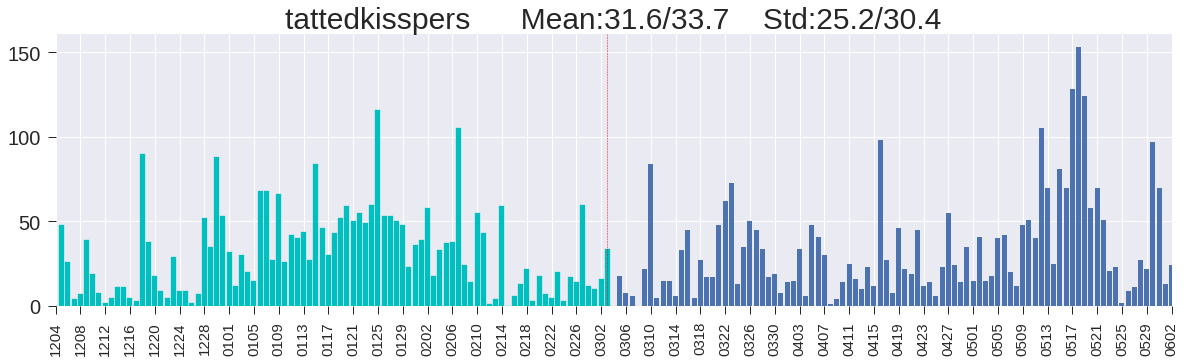

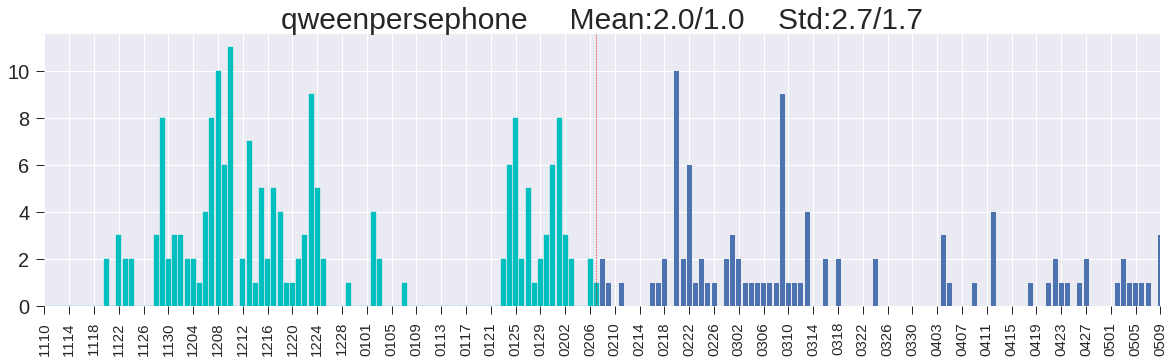

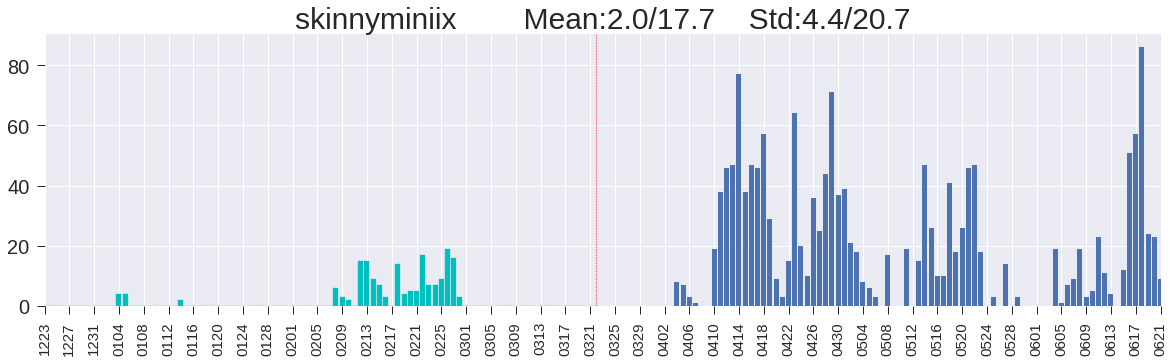

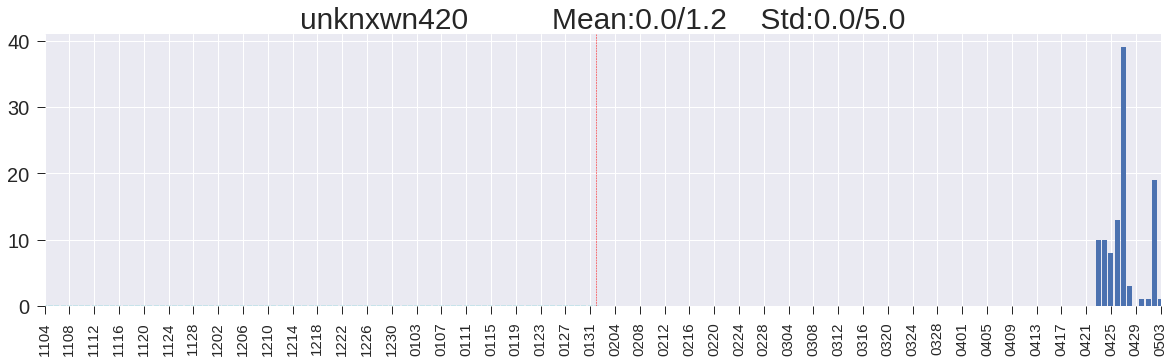

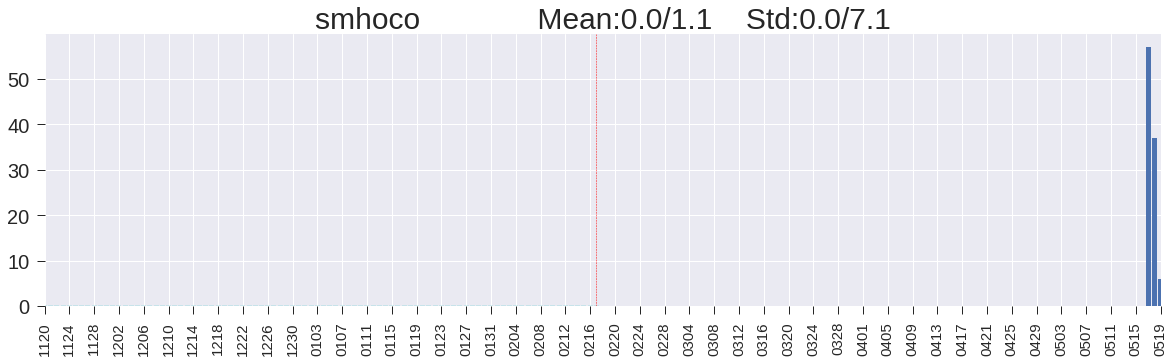

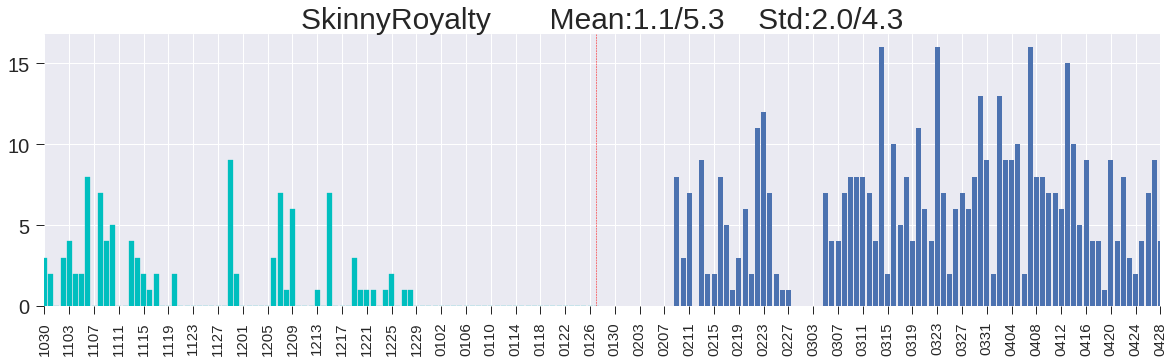

KeyboardInterrupt: 

In [128]:
for patient in patients:
    plotUserGraph(patient)
#     break